<h2>Appendix 12 - Aggregate Sentiment Trends</h2>

The results ascertained below are explored in detail in the Data Exploration portion of our study. Additional steps that were conducted at the data exploration stage but did not produce noteworthy results have not been included in this appendix.

<h3>Imports and functions for repeated use in plots</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from mpl_toolkits import mplot3d
from scipy.stats import mode
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [2]:
# Function to automate labelling charts
def set_title_labels(title, xlabel, ylabel):
    plt.title(title).set_fontsize(18)
    plt.xlabel(xlabel).set_fontsize(14)
    plt.ylabel(ylabel).set_fontsize(14)  
    
# Function to automate plotting linear regression
def plot_lin_reg(x, y, colour):
    model = LinearRegression(normalize=True)
    x = np.asarray(x)
    X = x[:, np.newaxis]
    model.fit(X, y)
    plt.plot(X, model.predict(X), c = colour)

# Function to automate annotation of correlation coefficient, statistical significance
def annotate_r_p(x,y):
    r = pearsonr(x,y)[0]
    p = pearsonr(x,y)[1]
    plt.annotate("r: %.2f" % r, xy = (0.8, 0.95), xycoords = "axes fraction")
    plt.annotate("p: %.2f" % p, xy = (0.9, 0.95), xycoords = "axes fraction")
    
# Function to assign colour value to male and female points on scatter graphs
def gender_to_colour(gender):
    if gender == "F":
        return "r"
    else:
        return "b"

# Function to plot two linear regressions, for comparison of male/female differences
def plot_two_regs(xf, yf, xm, ym, cf, cm):
    plot_lin_reg(xf, yf, cf)
    plot_lin_reg(xm, ym, cm)
    rf = pearsonr(xf,yf)[0]
    pf = pearsonr(xf,yf)[1]
    plt.annotate("rf: %.2f" % rf, xy = (0.8, 0.97), xycoords = "axes fraction")
    plt.annotate("pf: %.2f" % pf, xy = (0.9, 0.97), xycoords = "axes fraction")
    rm = pearsonr(xm,ym)[0]
    pm = pearsonr(xm,ym)[1]
    plt.annotate("rm: %.2f" % rm, xy = (0.8, 0.95), xycoords = "axes fraction")
    plt.annotate("pm: %.2f" % pm, xy = (0.9, 0.95), xycoords = "axes fraction") 

# Function to create super figure where multiple subplots are required
def create_sup_figure(x, y, top_start, title, font_size):
    plt.figure(figsize = (x,y)).subplots_adjust(top = top_start)
    plt.suptitle(title).set_fontsize(font_size)

<h3>Aggregating sentiment values by state, adding vote share and population stats</h3>

In [3]:
tweet_data = pd.read_excel("05sotu_with_tb_sentiment.xlsx")

In [4]:
# Read in sheet with population, census region, census division, Trump vote share, and Clinton vote share for each state
vote_share = pd.read_excel("vote_share.xlsx", index_col = [0])
vote_share

,T_vote_share,C_vote_share,population,Census_Region,Census_Division
STATE,,,,,
AK,0.5128,0.3655,710249.0,4,9
AL,0.6208,0.3436,4780127.0,3,6
AR,0.6057,0.3365,2915958.0,3,7
AZ,0.4867,0.4513,6392307.0,4,8
CA,0.3162,0.6173,37254503.0,4,9
CO,0.4325,0.4816,5029324.0,4,8
CT,0.4093,0.5457,3574118.0,1,1
DC,0.0407,0.9048,601767.0,3,5
DE,0.4172,0.5309,897936.0,3,5


In [5]:
# Group data by state, with count of occurrences of each state
state_stats = tweet_data.groupby(["state"])["state"].count()
state_stats = state_stats.to_frame()
state_stats.columns = ["occurrences"]
state_stats

# Add mean polarity and subjectivity of tweets from each state to the dataframe
state_stats["polarity"] = tweet_data.groupby(["state"])["tbpolarity"].mean()
state_stats["subjectivity"] = tweet_data.groupby(["state"])["tbsubjectivity"].mean()

# Add vote share, differential, population, tweet:population ratio, census region, census division
state_stats["T_vote_share"] = vote_share["T_vote_share"]
state_stats["C_vote_share"] = vote_share["C_vote_share"]
state_stats["T_C_differential"] = state_stats["T_vote_share"] - state_stats["C_vote_share"]
state_stats["population"] = vote_share["population"]
state_stats["population_ratio"] = state_stats.drop(["USA"])["population"] / state_stats.drop(["USA"])["population"].sum()
state_stats["occurrence_ratio"] = state_stats.drop(["USA"])["occurrences"] / state_stats.drop(["USA"])["occurrences"].sum()
state_stats["occurrence:population"] = state_stats["occurrence_ratio"]/state_stats["population_ratio"]
state_stats["census_region"] = vote_share["Census_Region"]
state_stats["census_division"] = vote_share["Census_Division"]

# Add vote differnetial groupings
x = [x for x in state_stats["T_C_differential"]]
diff_binned4, diff_bins4 = pd.qcut(x, 4, retbins = True)
diff_binned9, diff_bins9 = pd.qcut(x, 9, retbins = True)
state_stats["diff_bin4"] = np.fmin(np.digitize(x, diff_bins4), 4)
state_stats["diff_bin9"] = np.fmin(np.digitize(x, diff_bins9), 9)

state_stats

,occurrences,polarity,subjectivity,T_vote_share,C_vote_share,T_C_differential,population,population_ratio,occurrence_ratio,occurrence:population,census_region,census_division,diff_bin4,diff_bin9
state,,,,,,,,,,,,,,
AK,212,0.073306,0.384363,0.5128,0.3655,0.1473,710249.0,0.002300,0.001355,0.589139,4,9,3,6
AL,1730,0.055522,0.350151,0.6208,0.3436,0.2772,4780127.0,0.015482,0.011059,0.714331,3,6,4,8
AR,882,0.067677,0.331489,0.6057,0.3365,0.2692,2915958.0,0.009444,0.005638,0.597008,3,7,4,8
AZ,2493,0.069697,0.343183,0.4867,0.4513,0.0354,6392307.0,0.020703,0.015937,0.769764,4,8,3,5
CA,18295,0.056695,0.350007,0.3162,0.6173,-0.3011,37254503.0,0.120659,0.116952,0.969274,4,9,1,1
CO,2625,0.058206,0.355221,0.4325,0.4816,-0.0491,5029324.0,0.016289,0.016780,1.030178,4,8,2,3
CT,1596,0.062651,0.347342,0.4093,0.5457,-0.1364,3574118.0,0.011576,0.010203,0.881367,1,1,1,2
DC,12025,0.073104,0.339852,0.0407,0.9048,-0.8641,601767.0,0.001949,0.076870,39.441142,3,5,1,1
DE,383,0.088062,0.355515,0.4172,0.5309,-0.1137,897936.0,0.002908,0.002448,0.841872,3,5,1,3


<h3>K-Means Clustering</h3>

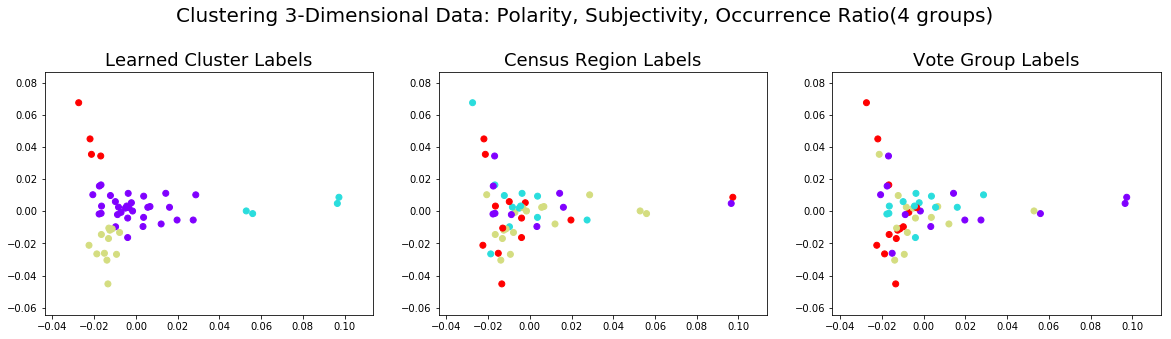

Cluster quality, Census Groups:
Homogeneity: 0.116
Completeness: 0.151
V-measure: 0.131

Cluster quality, Vote Groups:
Homogeneity: 0.181
Completeness: 0.240
V-measure: 0.206


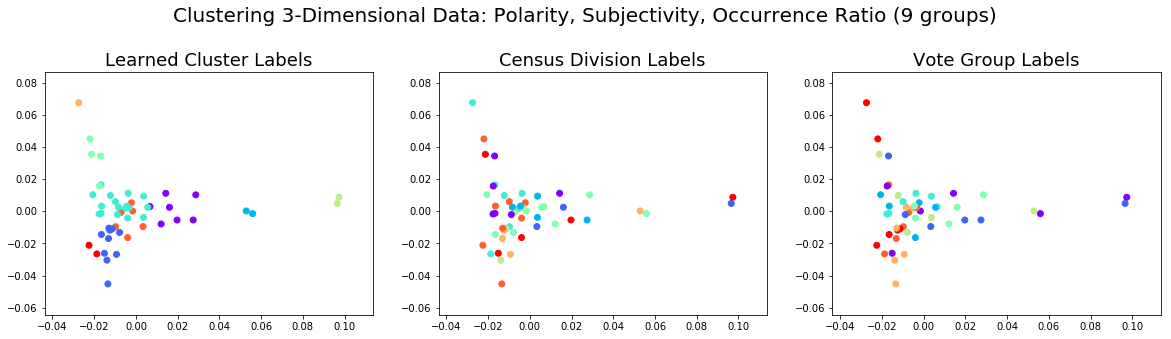

Cluster quality, Census Groups:
Homogeneity: 0.322
Completeness: 0.370
V-measure: 0.344

Cluster quality, Vote Groups:
Homogeneity: 0.376
Completeness: 0.441
V-measure: 0.406


In [6]:
df = state_stats.drop(["USA"])  # Drop "USA" row
cluster_stats = np.vstack((df["polarity"], df["subjectivity"], df["occurrence_ratio"])).T  # Select 3 dimensions for clustering
est = KMeans(4)  # Create K-Means estimator object to identify 4 clusters
clusters = est.fit_predict(cluster_stats)

# Label clusters for later colouring
labels = np.zeros_like(clusters)

for i in range(1, 5):
    mask = (clusters == i)
    labels[mask] = clusters[mask]

create_sup_figure(20, 5, 0.8, 'Clustering 3-Dimensional Data: Polarity, Subjectivity, Occurrence Ratio(4 groups)', 20)

# Plot four learned cluster labels
plt.subplot(131)
X = PCA(2).fit_transform(cluster_stats)
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'rainbow')
set_title_labels("Learned Cluster Labels","","")

# Plot four known census region labels
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c = df["census_region"], cmap = 'rainbow')
set_title_labels("Census Region Labels","","")

# Plot four known vote differential groups
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c = df["diff_bin4"], cmap = 'rainbow')
set_title_labels("Vote Group Labels","","")
plt.show()

# http://scikit-learn.org/stable/modules/clustering.html
# Intuitive metrics of the quality of clustering results based on known pre-existing classes
# Homogeneity: each cluster contains only members of a single class
# Completeness: all members of a given class are assigned to the same cluster
# Both are bounded below by 0.0 and above by 1.0 (higher is better)
# Their harmonic mean is called the V-measure

print("Cluster quality, Census Groups:")
print("Homogeneity: %0.3f" % homogeneity_score(df["census_region"], labels))
print("Completeness: %0.3f" % completeness_score(df["census_region"], labels))
print("V-measure: %0.3f" % v_measure_score(df["census_region"], labels))
print("\nCluster quality, Vote Groups:")
print("Homogeneity: %0.3f" % homogeneity_score(df["diff_bin4"], labels))
print("Completeness: %0.3f" % completeness_score(df["diff_bin4"], labels))
print("V-measure: %0.3f" % v_measure_score(df["diff_bin4"], labels))

# Create K-Means estimator object to identify 9 clusters
est = KMeans(9)
clusters = est.fit_predict(cluster_stats)

# Label clusters for later colouring
labels = np.zeros_like(clusters)

for i in range(1, 10):
    mask = (clusters == i)
    labels[mask] = clusters[mask]

create_sup_figure(20, 5, 0.8, 'Clustering 3-Dimensional Data: Polarity, Subjectivity, Occurrence Ratio (9 groups)', 20)

# Plot nine learned cluster labels
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'rainbow')
set_title_labels("Learned Cluster Labels","","")

# Plot nine known census division labels
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c = df["census_division"], cmap = 'rainbow')
set_title_labels("Census Division Labels","","")

# Plot nine known vote differential groups
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c = df["diff_bin9"], cmap = 'rainbow')
set_title_labels("Vote Group Labels","","")
plt.show()

print("Cluster quality, Census Groups:")
print("Homogeneity: %0.3f" % homogeneity_score(df["census_division"], labels))
print("Completeness: %0.3f" % completeness_score(df["census_division"], labels))
print("V-measure: %0.3f" % v_measure_score(df["census_division"], labels))
print("\nCluster quality, Vote Groups:")
print("Homogeneity: %0.3f" % homogeneity_score(df["diff_bin9"], labels))
print("Completeness: %0.3f" % completeness_score(df["diff_bin9"], labels))
print("V-measure: %0.3f" % v_measure_score(df["diff_bin9"], labels))

<h3>Visualising Variance Across States by Vote Differential</h3>

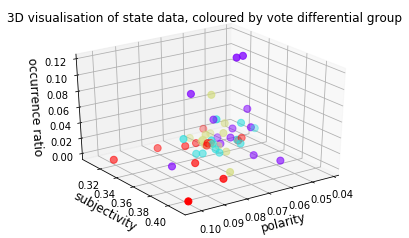

In [7]:
# Create 3D subplot and scatter values for three chosen dimensions
ax = plt.subplot(projection='3d')
ax.set
ax.scatter3D(df["polarity"], df["subjectivity"], df["occurrence_ratio"], c = df["diff_bin4"], s = 50, cmap = "rainbow")

# Set viewing angle and labels
ax.view_init(30, 55)
ax.set_xlabel('polarity').set_fontsize(12)
ax.set_ylabel('subjectivity').set_fontsize(12)
ax.set_zlabel('occurrence ratio').set_fontsize(12)

plt.title('3D visualisation of state data, coloured by vote differential group').set_fontsize(12)
plt.show()

<h3>Tweets by state</h3>

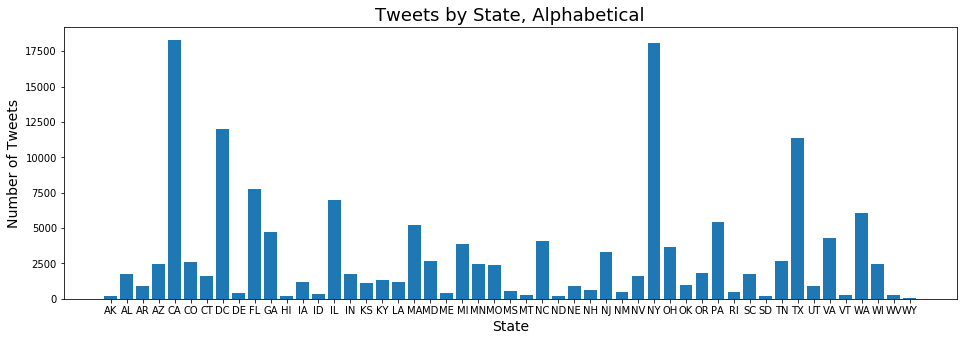

In [8]:
# Tweets by state, alphabetical
x = range(51)
y = [y for y in state_stats.drop(["USA"])["occurrences"]]

fig, ax = plt.subplots()
fig.set_size_inches((16,5))
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels([x for x in state_stats.drop(["USA"]).index])

set_title_labels("Tweets by State, Alphabetical", "State", "Number of Tweets")
plt.show()

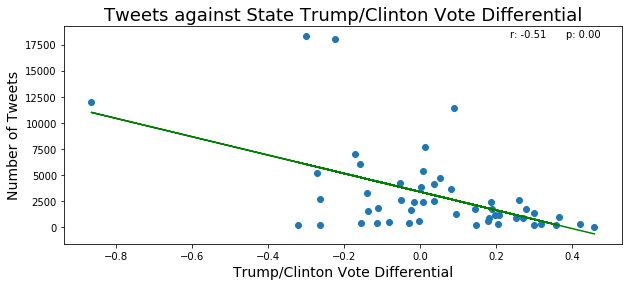

In [9]:
# Tweets against Trump/Clinton vote differential - above 0 indicates Trump-leaning state, below indicates CLinton-leaning
x = [x for x in state_stats.drop(["USA"])["T_C_differential"]]
plt.figure(figsize=(10,4))
plt.scatter(x,y)
c = "g"

plot_lin_reg(x,y,c)
annotate_r_p(x,y)
set_title_labels("Tweets against State Trump/Clinton Vote Differential", "Trump/Clinton Vote Differential", "Number of Tweets")
plt.show()

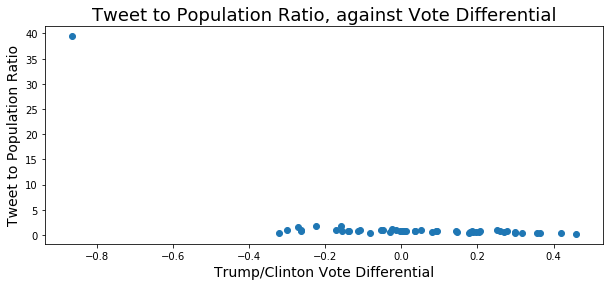

In [10]:
# Tweet to Poluation Ratio, against Vote Differential
y = [y for y in state_stats["occurrence:population"].drop(["USA"])]
plt.figure(figsize=(10,4))
plt.scatter(x,y)

set_title_labels("Tweet to Population Ratio, against Vote Differential", "Trump/Clinton Vote Differential", "Tweet to Population Ratio")
plt.show()

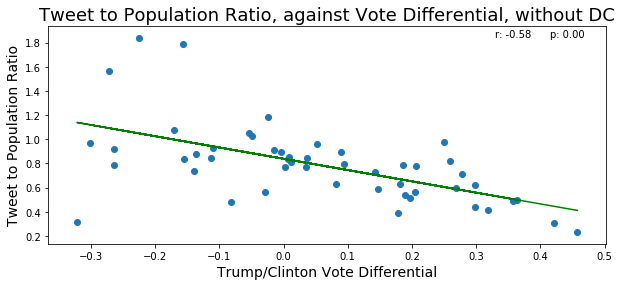

In [11]:
# Removing outlier DC
# The plot exhibits heteroscedasticity - systematically greater variance in residual between actual value and that predicted
# by the trend line. In this instance we see that variance is greater the more left-leaning the state. This would represent
# an issue if we were to use this to predict tweet to population ratio based on vote differential, not the purpose of our study
x = [x for x in state_stats["T_C_differential"].drop(["DC","USA"])]
y = [y for y in state_stats["occurrence:population"].drop(["DC","USA"])]
plt.figure(figsize=(10,4))
plt.scatter(x,y)

plot_lin_reg(x,y,c)
annotate_r_p(x,y)
set_title_labels("Tweet to Population Ratio, against Vote Differential, without DC", "Trump/Clinton Vote Differential", "Tweet to Population Ratio")
plt.show()

<h3>Polarity and Subjectivity By State</h3>

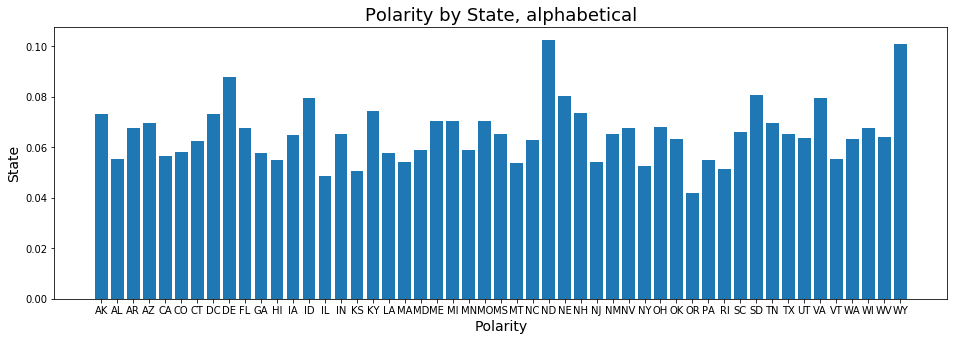

In [12]:
# Polarity by state, alphabetical
x = range(51)
y = [y for y in state_stats.drop(["USA"])["polarity"]]

fig, ax = plt.subplots()
fig.set_size_inches((16,5))
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels([x for x in state_stats.drop(["USA"]).index])

set_title_labels("Polarity by State, alphabetical", "Polarity", "State")
plt.show()

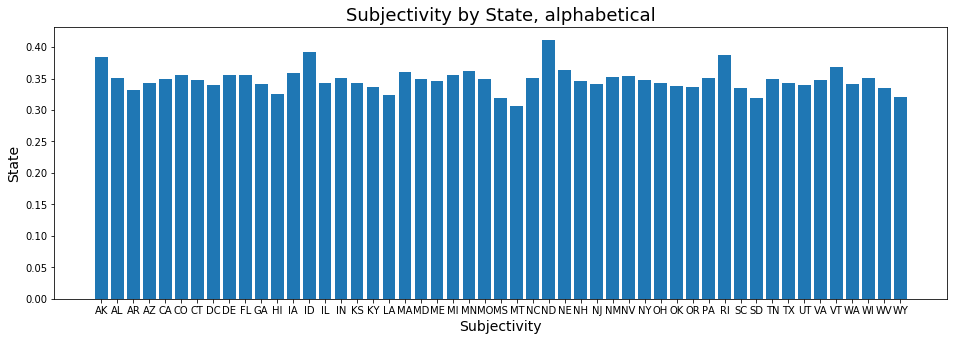

In [13]:
# Subjectivity by state, alphabetical
y = [y for y in state_stats.drop(["USA"])["subjectivity"]]

fig, ax = plt.subplots()
fig.set_size_inches((16,5))
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels([x for x in state_stats.drop(["USA"]).index])

set_title_labels("Subjectivity by State, alphabetical", "Subjectivity", "State")
plt.show()

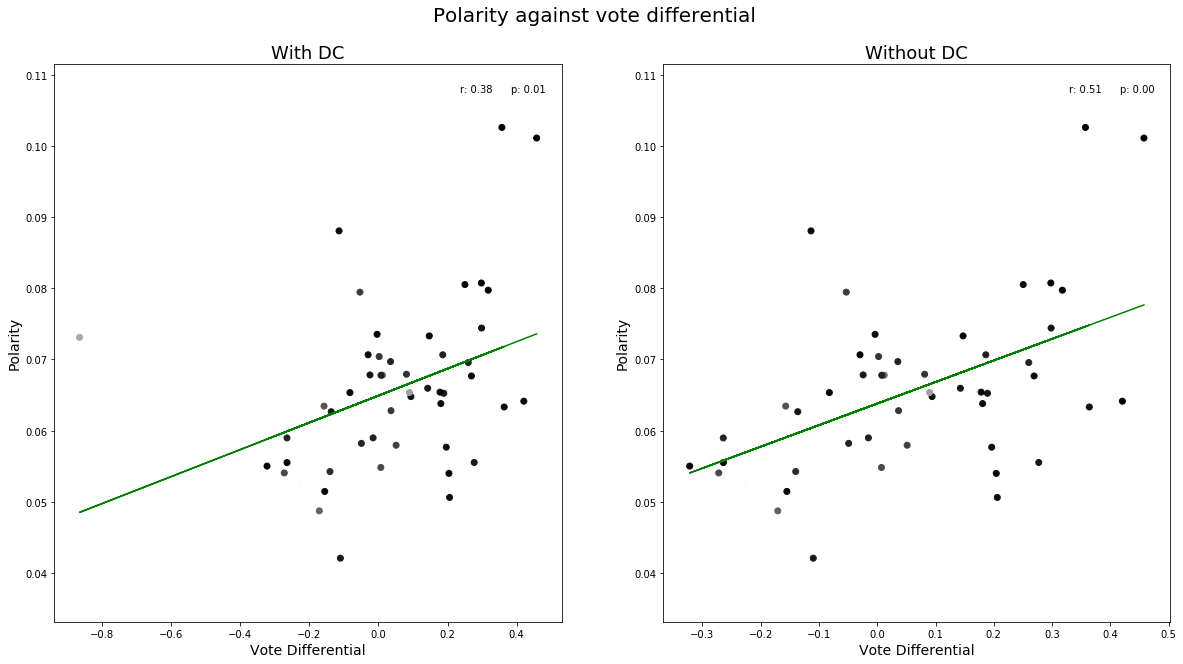

In [14]:
# Polarity against vote differential by state, darker shade indicates higher number of occurrences of the given state
x = [x for x in state_stats.drop(["USA"])["T_C_differential"]]
y = [y for y in state_stats.drop(["USA"])["polarity"]]
z = [z for z in state_stats.drop(["USA"])["occurrences"]]

create_sup_figure(20, 10, 0.9, 'Polarity against vote differential', 20)
plt.subplot(121)
plt.gray()
plt.scatter(x, y, c=z)
set_title_labels("With DC", "Vote Differential", "Polarity")

plot_lin_reg(x,y,c)
annotate_r_p(x,y)

x = [x for x in state_stats.drop(["DC", "USA"])["T_C_differential"]]
y = [y for y in state_stats.drop(["DC", "USA"])["polarity"]]
z = [z for z in state_stats.drop(["DC", "USA"])["occurrences"]]

plt.subplot(122)
plt.gray()
plt.scatter(x, y, c=z)
set_title_labels("Without DC", "Vote Differential", "Polarity")

plot_lin_reg(x,y,c)
annotate_r_p(x,y)

plt.show()

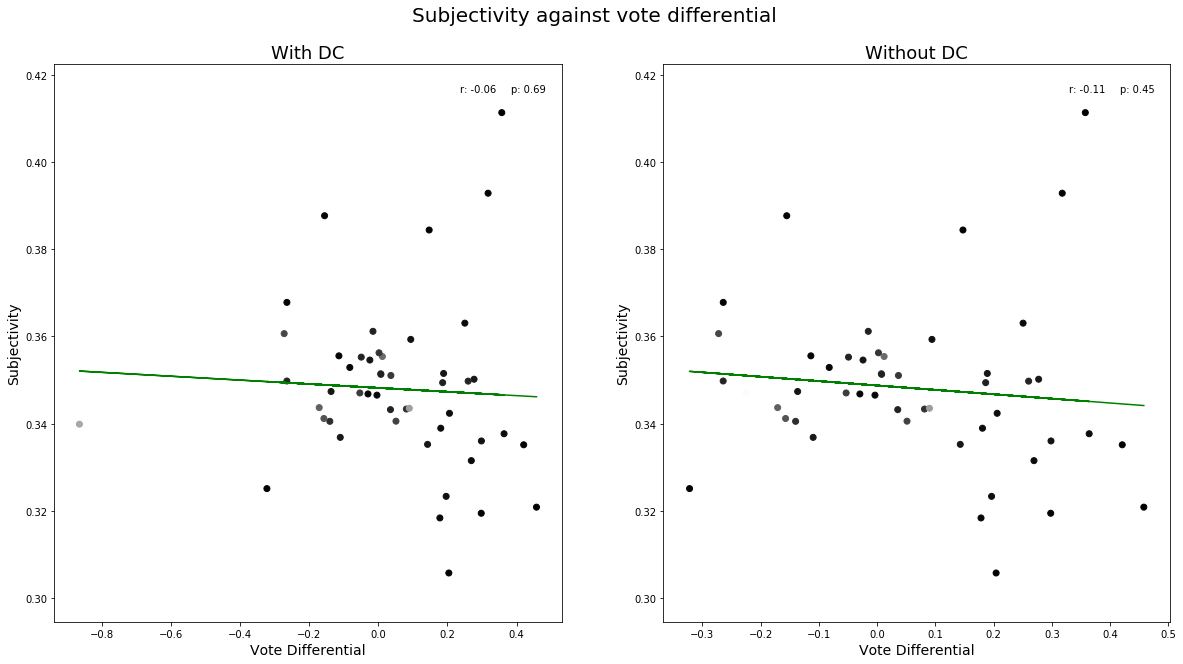

In [15]:
# Subjectivity against vote differential by state, darker shade indicates higher number of occurrences of the given state
x = [x for x in state_stats.drop(["USA"])["T_C_differential"]]
y = [y for y in state_stats.drop(["USA"])["subjectivity"]]
z = [z for z in state_stats.drop(["USA"])["occurrences"]]

create_sup_figure(20, 10, 0.9, 'Subjectivity against vote differential', 20)
plt.subplot(121)
plt.gray()
plt.scatter(x, y, c=z)
set_title_labels("With DC", "Vote Differential", "Subjectivity")

plot_lin_reg(x,y,c)
annotate_r_p(x,y)

x = [x for x in state_stats.drop(["DC", "USA"])["T_C_differential"]]
y = [y for y in state_stats.drop(["DC", "USA"])["subjectivity"]]
z = [z for z in state_stats.drop(["DC", "USA"])["occurrences"]]

plt.subplot(122)
plt.gray()
plt.scatter(x, y, c=z)
set_title_labels("Without DC", "Vote Differential", "Subjectivity")

plot_lin_reg(x,y,c)
annotate_r_p(x,y)

plt.show()

<h3>Polarity and Subjectivity By State and Gender</h3>

In [16]:
# Group data by state and gender, with count of occurrences of each gender for each state
state_stats_gender = tweet_data.groupby(["state","gender"])["gender"].count()
state_stats_gender = state_stats_gender.to_frame()
state_stats_gender.columns = ["occurrences"]

# Add mean polarity and subjectivity of tweets from each state group by gender
state_stats_gender["polarity"] = tweet_data.groupby(["state", "gender"])["tbpolarity"].mean()
state_stats_gender["subjectivity"] = tweet_data.groupby(["state", "gender"])["tbsubjectivity"].mean()

states = [x[0] for x in state_stats_gender.index]

# Add vote share, differential
for state in states:
    T_vote_share = vote_share.at[state, "T_vote_share"]
    C_vote_share = vote_share.at[state, "C_vote_share"]
    state_stats_gender.at[state, "T_vote_share"] = T_vote_share
    state_stats_gender.at[state, "C_vote_share"] = C_vote_share
    state_stats_gender.at[state, "T_C_differential"] = T_vote_share - C_vote_share

state_stats_gender

occurrences  polarity  subjectivity  T_vote_share  C_vote_share  \
state gender                                                                    
AK    F                62  0.098829      0.403653        0.5128        0.3655   
      M                71  0.064998      0.405904        0.5128        0.3655   
AL    F               343  0.077202      0.321289        0.6208        0.3436   
      M               583  0.049710      0.350132        0.6208        0.3436   
AR    F               219  0.078117      0.299247        0.6057        0.3365   
      M               366  0.043319      0.368917        0.6057        0.3365   
AZ    F               580  0.068340      0.349590        0.4867        0.4513   
      M               860  0.069315      0.351429        0.4867        0.4513   
CA    F              4298  0.052165      0.346143        0.3162        0.6173   
      M              5456  0.063547      0.357580        0.3162        0.6173   
CO    F               618  0.068240      0.354858        0.4325        0.4816   
      M               733  0.065890      0.348642        0.4325        0.4816   
CT    F               428  0.040563      0.367105        0.4093        0.5457   
      M               450  0.055719      0.346474        0.4093        0.5457   
DC    F              2960  0.062197      0.338731        0.0407        0.9048   
      M              3368  0.072936      0.351924        0.0407        0.9048   
DE    F                75  0.041394      0.389283        0.4172        0.5309   
      M               114  0.136170      0.373634        0.4172        0.5309   
FL    F              1812  0.082272      0.350250        0.4902        0.4782   
      M              2289  0.066803      0.359378        0.4902        0.4782   
GA    F              1056  0.056571      0.338809        0.5077        0.4564   
      M              1569  0.071379      0.350422        0.5077        0.4564   
HI    F                56  0.084311      0.342747        0.3003        0.6222   
      M                71  0.033848      0.331920        0.3003        0.6222   
IA    F               287  0.057239      0.359329        0.5115        0.4174   
      M               541  0.061485      0.350397        0.5115        0.4174   
ID    F                98  0.000131      0.348512        0.5926        0.2749   
      M                88  0.103156      0.445210        0.5926        0.2749   
IL    F              1407  0.035357      0.337159        0.3876        0.5583   
      M              2200  0.053558      0.350910        0.3876        0.5583   
...                   ...       ...           ...           ...           ...   
OR    F               367  0.022767      0.372516        0.3909        0.5007   
      M               509  0.062630      0.331318        0.3909        0.5007   
PA    F              1183  0.059910      0.345930        0.4818        0.4746   
      M              1824  0.056665      0.358932        0.4818        0.4746   
RI    F               125  0.049366      0.388159        0.3890        0.5441   
      M               119  0.010867      0.400157        0.3890        0.5441   
SC    F               307  0.070547      0.366309        0.5494        0.4067   
      M               640  0.063655      0.317717        0.5494        0.4067   
SD    F                49  0.115383      0.358624        0.6153        0.3174   
      M                65  0.058365      0.321018        0.6153        0.3174   
TN    F               618  0.071894      0.352198        0.6072        0.3472   
      M              1031  0.085247      0.354566        0.6072        0.3472   
TX    F              2631  0.078520      0.351687        0.5223        0.4324   
      M              3781  0.071880      0.344433        0.5223        0.4324   
USA   F              3158  0.070011      0.351183        0.4609        0.4818   
      M              3144  0.065720      0.347326        0.4609        0.4818   
UT    F               187  0.049166      0.37

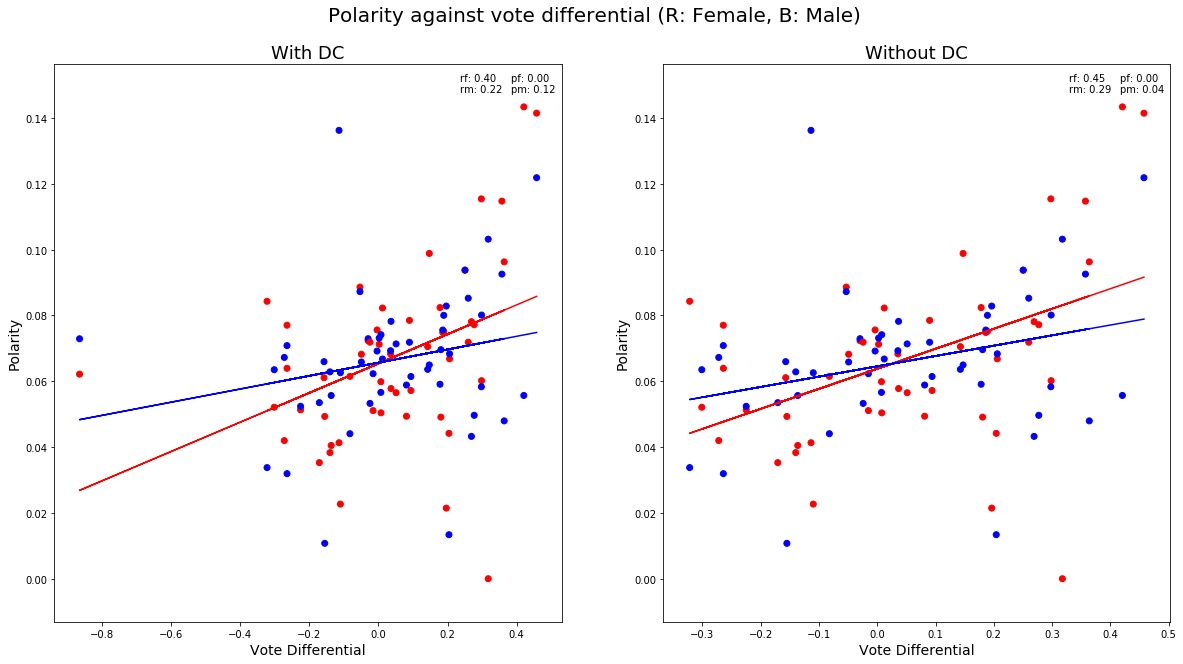

In [17]:
# Polarity against vote share differential by state, red indicates female and blue indicates male
x = [x for x in state_stats_gender.drop(["USA"])["T_C_differential"]]
y = [y for y in state_stats_gender.drop(["USA"])["polarity"]]
z = [gender_to_colour(z[1]) for z in state_stats_gender.drop(["USA"]).index]

create_sup_figure(20, 10, 0.9, 'Polarity against vote differential (R: Female, B: Male)', 20)
plt.subplot(121)
plt.scatter(x, y, c = z)
set_title_labels("With DC", "Vote Differential", "Polarity")

xf = [x for x in state_stats_gender.xs("F", level = "gender").drop(["USA"])["T_C_differential"]]
yf = [y for y in state_stats_gender.xs("F", level = "gender").drop(["USA"])["polarity"]]
xm = [x for x in state_stats_gender.xs("M", level = "gender").drop(["USA"])["T_C_differential"]]
ym = [y for y in state_stats_gender.xs("M", level = "gender").drop(["USA"])["polarity"]]

plot_two_regs(xf,yf,xm,ym,"r","b")

x = [x for x in state_stats_gender.drop(["DC", "USA"])["T_C_differential"]]
y = [y for y in state_stats_gender.drop(["DC", "USA"])["polarity"]]
z = [gender_to_colour(z[1]) for z in state_stats_gender.drop(["DC", "USA"]).index]

plt.subplot(122)
plt.scatter(x, y, c=z)
set_title_labels("Without DC", "Vote Differential", "Polarity")

xf = [x for x in state_stats_gender.xs("F", level = "gender").drop(["DC", "USA"])["T_C_differential"]]
yf = [y for y in state_stats_gender.xs("F", level = "gender").drop(["DC", "USA"])["polarity"]]
xm = [x for x in state_stats_gender.xs("M", level = "gender").drop(["DC", "USA"])["T_C_differential"]]
ym = [y for y in state_stats_gender.xs("M", level = "gender").drop(["DC", "USA"])["polarity"]]

plot_two_regs(xf,yf,xm,ym,"r","b")

plt.show()

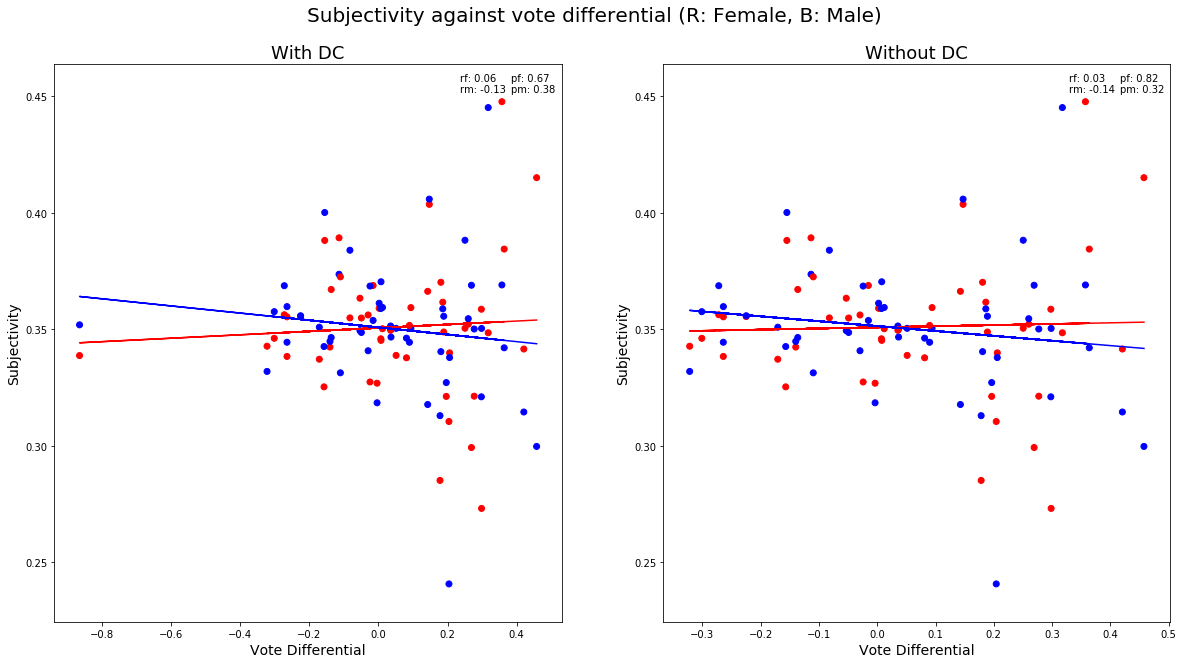

In [18]:
# Subjectivity against vote share by state, red indicates female and blue indicates male
x = [x for x in state_stats_gender.drop(["USA"])["T_C_differential"]]
y = [y for y in state_stats_gender.drop(["USA"])["subjectivity"]]
z = [gender_to_colour(z[1]) for z in state_stats_gender.drop(["USA"]).index]

create_sup_figure(20, 10, 0.9, 'Subjectivity against vote differential (R: Female, B: Male)', 20)
plt.subplot(121)
plt.scatter(x, y, c=z)
set_title_labels("With DC", "Vote Differential", "Subjectivity")

xf = [x for x in state_stats_gender.xs("F", level = "gender").drop(["USA"])["T_C_differential"]]
yf = [y for y in state_stats_gender.xs("F", level = "gender").drop(["USA"])["subjectivity"]]
xm = [x for x in state_stats_gender.xs("M", level = "gender").drop(["USA"])["T_C_differential"]]
ym = [y for y in state_stats_gender.xs("M", level = "gender").drop(["USA"])["subjectivity"]]

plot_two_regs(xf,yf,xm,ym,"r","b")

x = [x for x in state_stats_gender.drop(["DC", "USA"])["T_C_differential"]]
y = [y for y in state_stats_gender.drop(["DC", "USA"])["subjectivity"]]
z = [gender_to_colour(z[1]) for z in state_stats_gender.drop(["DC", "USA"]).index]

plt.subplot(122)
plt.scatter(x, y, c=z)
set_title_labels("Without DC", "Vote Differential", "Subjectivity")

xf = [x for x in state_stats_gender.xs("F", level = "gender").drop(["DC", "USA"])["T_C_differential"]]
yf = [y for y in state_stats_gender.xs("F", level = "gender").drop(["DC", "USA"])["subjectivity"]]
xm = [x for x in state_stats_gender.xs("M", level = "gender").drop(["DC", "USA"])["T_C_differential"]]
ym = [y for y in state_stats_gender.xs("M", level = "gender").drop(["DC", "USA"])["subjectivity"]]

plot_two_regs(xf,yf,xm,ym,"r","b")

plt.show()

<h3>Tweets over Time</h3>

In [19]:
for i in range(len(tweet_data["date"])):
    tweet_data.at[i, "datetime"] = datetime = datetime.strptime(tweet_data.at[i, "date"][11:19], "%H:%M:%S")
    tweet_data.at[i, "timestamp"] = (datetime.second - 14) + 60*(datetime.minute - 10) + 3600*(datetime.hour - 2)

C:\Users\Alex\Anaconda3\Lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


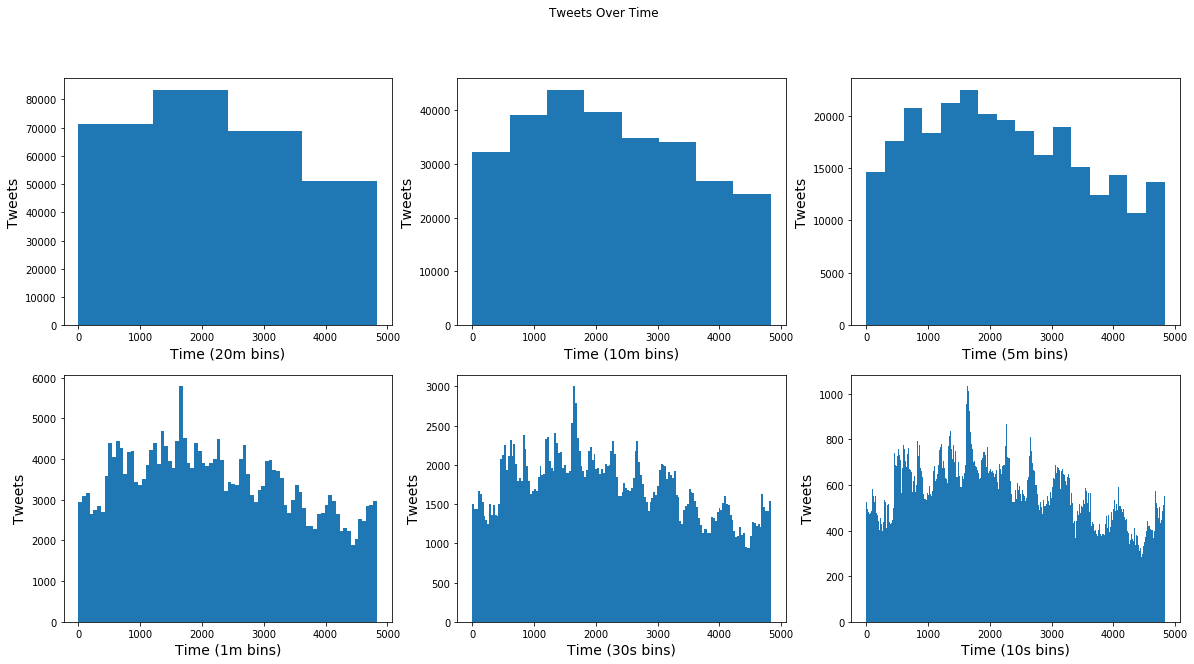

In [20]:
x = [x for x in tweet_data["timestamp"]]
plt.figure(figsize=(20,10))
plt.suptitle("Tweets Over Time")
plt.subplot(2,3,1)
plt.hist(x, bins = 4) # ~20 minute bins
plt.subplot(2,3,2)
plt.hist(x, bins = 8) # ~10 minute bins
plt.subplot(2,3,3)
plt.hist(x, bins = 16) # ~5 minute bins
plt.subplot(2,3,4)
plt.hist(x, bins = 80) # ~1 minute bins
plt.subplot(2,3,5)
plt.hist(x, bins = 160) # ~30 second bins
plt.subplot(2,3,6)
plt.hist(x, bins = 480) # ~10 second bins

units = [" (20m bins)", " (10m bins)", " (5m bins)", " (1m bins)", " (30s bins)", " (10s bins)"]

for i in range(1,7):
    plt.subplot(2,3,i)
    set_title_labels("", "Time" + units[i-1], "Tweets")

plt.show()

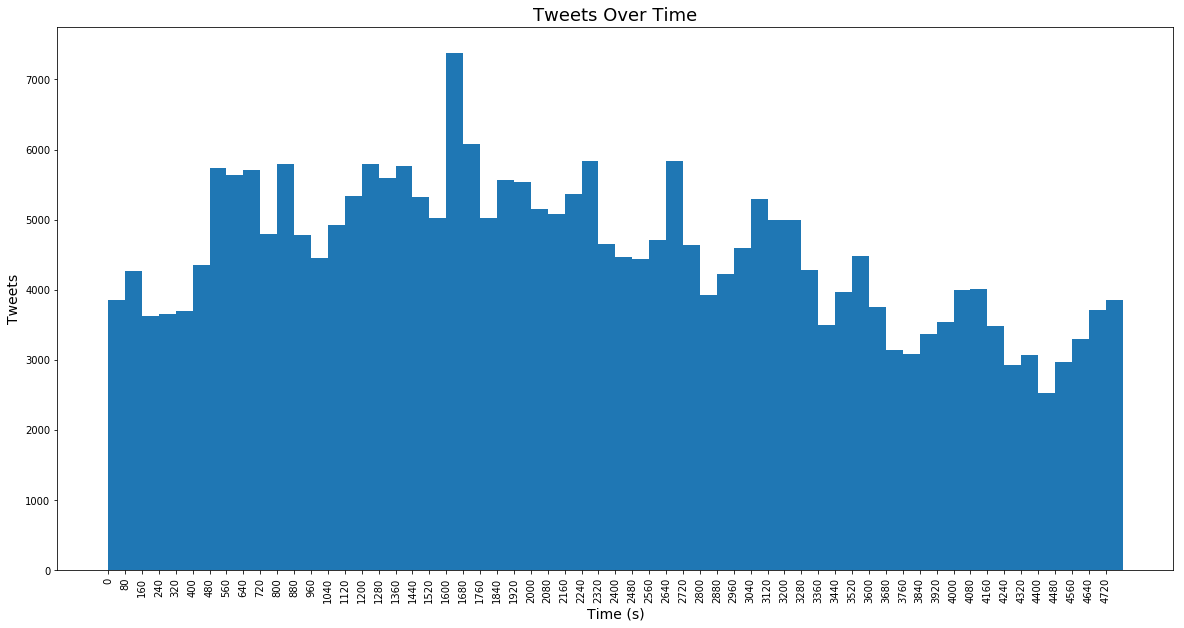

In [21]:
x = [x for x in tweet_data["timestamp"]]
plt.figure(figsize=(20,10))
plt.hist(x, bins = [x for x in np.arange(0, 4832, 80)], range = (0,4832))
plt.xticks([x for x in np.arange(0, 4800, 80)], rotation = 90)
set_title_labels("Tweets Over Time", "Time (s)", "Tweets")

plt.show()